# **Direct and Gobal Separation**
**Direct and Global lighting separation** is done by passing an occluder over a fixed video, then applying a min and max filter, and 


In [1]:
#@title Imports
from google.colab import drive
import ipywidgets as widgets

#Import Libraries

In [2]:
from pylab import rcParams
import matplotlib.pyplot as plt
import ipywidgets as widgets
import cv2
import numpy as np

import os
from google.colab import drive
from google.colab import files

**Function Setup**

In [3]:
def file_upload():
  uploaded = files.upload()
  # for fn in uploaded.keys():
    # print('User uploaded file "{name}" with length {length} bytes'.format(
    #    name=fn, length=len(uploaded[fn])))
  return uploaded.keys()

def display_image(a, title = "Original"):
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    plt.imshow(a), plt.title(title)
    plt.show()


def combine_images(img1, img2):
    """Combines direct and global light
    Adds together direct and global light images
    :param img1, img2: Images to combine
    :type class:numpy.ndarray
    :returns: Combined image
    :rtype: :class:`numpy.ndarray`
    """
    img1 = img1.astype('uint16')
    img2 = img2.astype('uint16')

    img = cv2.add(img1, img2)
    norm_img = img.astype(np.float64) / img.max()  # normalize the data to 0 - 1
    norm_img = 255.0 * norm_img # Now scale by 255

    img = norm_img.astype(np.uint8)

    return img


def direct_global_separation(video, video_name, width, height):
    """Separates direct and global light
    Loads a cv2 video into a list of frame images.
    :param video: The incoming cv2 video to be converted
    to a direct and a global cv2 image
    :type video: cv2.VideoCapture
    :returns: A pair of cv2 images
    :rtype: :class:`numpy.ndarray`
    """
    # start_time = time.time()
    w = int(video.get(3))
    h = int(video.get(4))

    frames_list = []

    ret, frame = video.read()

    frames_list.append(cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA))
    # frames_counter = 1

    while ret:
        ret, frame = video.read()
        # frames_counter = frames_counter + 1
        if ret:
            frames_list.append(cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA))
        else:
            break

    # frames_list = frames_list[0:int(len(frames_list)/2)]
    lmax = np.maximum.reduce(frames_list)
    lmin = np.minimum.reduce(frames_list)

    # Lmax = Ld +βLg
    # Lmin = βLg
    # α = 1

    beta = 0.75
    lg = lmin / beta
    ld = lmax - ( beta * lg )

    return(ld, lg)


def scaling_ratio(frame_size, height, width):
    """Returns a ratio to scale an image to 255 pixels
    wide/high
    :param video: The incoming cv2 video to be converted
    to a direct and a global cv2 image
    :type video: cv2.VideoCapture
    :returns: A pair of cv2 images
    :rtype: :class:`numpy.ndarray`
    """
    return frame_size/max(height, width)

def generate_filtered_image(image, ldl, ldw, rgb, filter_int):
    # Inits a filter image with no mixing
    filter_img = np.full((ldl, ldw, 3), rgb, np.uint8)
    fused_img = cv2.addWeighted(image, (1 - filter_int), filter_img, filter_int, 0)

    return fused_img

def get_rgb_value():
  rgb = str(rgb_picker.value).lstrip('#')
  rgb = rgb.zfill(6)
  return np.array(tuple(int(rgb[i:i+2], 16) for i in (0, 2, 4)), np.uint8)[::-1]

def on_button_clicked_nf(b):
  with output_nf:
    # Clears the cell if new input is provided
    output_nf.clear_output(wait=True)
    rgb = get_rgb_value()
    display_image(combine_images(ld, lg), title="Recombined Image")
    # print('nf')

def on_button_clicked_df(b):
  with output_df:
    # Clears the cell if new input is provided
    output_df.clear_output(wait=True)
    rgb = get_rgb_value()
    recolored = generate_filtered_image(ld, len(ld), len(ld[0]), rgb, (filter_int.value/100.0))
    display_image(combine_images(recolored, lg), title="Recombined Image - Direct")
    # print('df')

def on_button_clicked_gf(b):
  with output_gf:
    # Clears the cell if new input is provided
    output_gf.clear_output(wait=True)
    rgb = get_rgb_value()
    recolored = generate_filtered_image(lg, len(lg), len(lg[0]), rgb, (filter_int.value/100.0))
    display_image(combine_images(recolored, ld), title="Recombined Image - Global")
    # print('gf')

**Variable Initialization**

In [4]:
rcParams['figure.figsize'] = 10, 10
frame_size = 640
size_mult = 1

rgb_picker = widgets.ColorPicker(
    concise=True,
    description='Filter',
    value='#0000',
    disabled=False
)

button_nf = widgets.Button(description="No Filtering")
output_nf = widgets.Output()
button_nf.on_click(on_button_clicked_nf)

button_df = widgets.Button(description="Direct Filtering")
output_df = widgets.Output()
button_df.on_click(on_button_clicked_df)

button_gf = widgets.Button(description="Global Filtering")
output_gf = widgets.Output()
button_gf.on_click(on_button_clicked_gf)

filter_int = widgets.IntSlider(value=0, max=100)

# **Input**

Add your video here!

In [5]:
files_keys = file_upload()
video_name = [key for key in files_keys]

Saving Curtain.mpg to Curtain (2).mpg


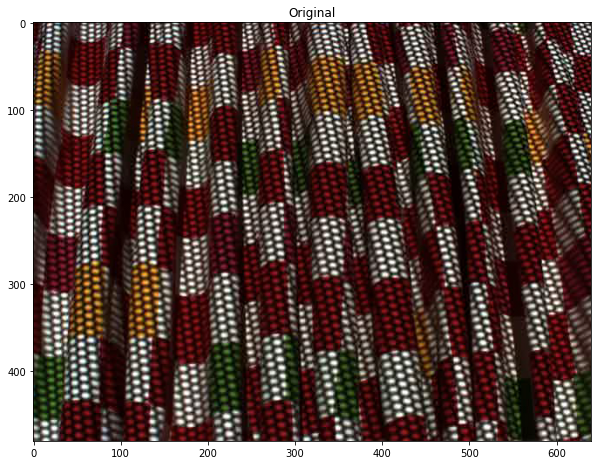

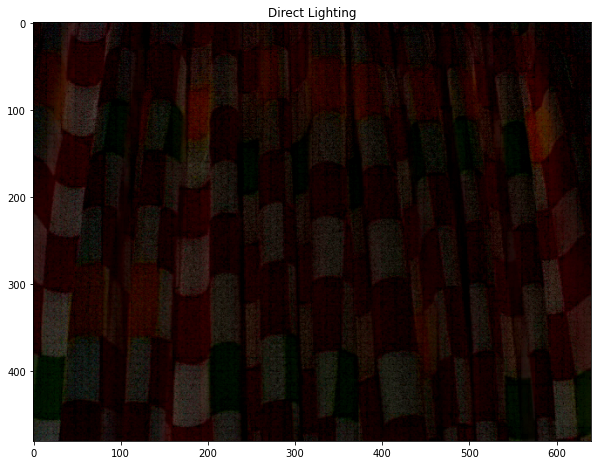

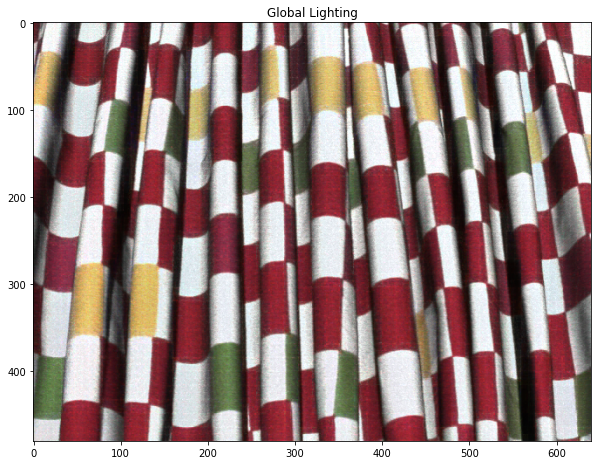

In [6]:
if len(video_name) > 1:
  print('You uploaded more than one file! If the wrong file is loaded, try re running the cell, and only load in one video.')

# Loads the Video into OpenCV
video = cv2.VideoCapture(video_name[0])

# Grabs the first frame in the video
ret, init_frame = video.read()

# Rescales the video to be smaller, for faster processing
if(len(init_frame) or len(init_frame[0])) > 1000:
  size_mult = scaling_ratio(frame_size, len(init_frame),len(init_frame[0]))

# Initializes the dimensions of the image
width = int(init_frame.shape[1] * size_mult)
height = int(init_frame.shape[0] * size_mult)

lg, ld = direct_global_separation(video, video_name, width, height)
lg = lg.astype('uint8')
ld = ld.astype('uint8')

display_image(init_frame, title='Original')
display_image(ld, title='Direct Lighting')
display_image(lg, title='Global Lighting')

In [7]:
print('RGB range')
display(rgb_picker)

print('Filtering Intensity')
display(filter_int)

display(button_nf, output_nf)
display(button_df, output_df)
display(button_gf, output_gf)

RGB range


ColorPicker(value='#0000', concise=True, description='Lower Bound for Color')

Filtering Intensity


IntSlider(value=0)

Button(description='No Filtering', style=ButtonStyle())

Output()

Button(description='Direct Filtering', style=ButtonStyle())

Output()

Button(description='Global Filtering', style=ButtonStyle())

Output()

# **Exercise 1**
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Quisque quis malesuada dui. Duis purus dui, imperdiet ultrices porta ut, tempus vel nisi. Proin vel urna sit amet mi sagittis iaculis quis vel magna. In laoreet eleifend enim quis dictum. Vivamus sed velit dictum, sagittis ipsum non, auctor erat. Nulla eget lobortis ligula, posuere faucibus erat. Nullam ac felis imperdiet libero viverra finibus sollicitudin consectetur libero. Quisque pharetra congue justo at varius. Nullam id quam nec sapien congue efficitur. Vivamus non scelerisque felis, id aliquam neque. Ut bibendum elementum diam, at efficitur nibh blandit ac. Vestibulum tincidunt tempor mattis.

# **Exercise 2**
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Quisque quis malesuada dui. Duis purus dui, imperdiet ultrices porta ut, tempus vel nisi. Proin vel urna sit amet mi sagittis iaculis quis vel magna. In laoreet eleifend enim quis dictum. Vivamus sed velit dictum, sagittis ipsum non, auctor erat. Nulla eget lobortis ligula, posuere faucibus erat. Nullam ac felis imperdiet libero viverra finibus sollicitudin consectetur libero. Quisque pharetra congue justo at varius. Nullam id quam nec sapien congue efficitur. Vivamus non scelerisque felis, id aliquam neque. Ut bibendum elementum diam, at efficitur nibh blandit ac. Vestibulum tincidunt tempor mattis.